# 1. Dependencies & Setup

In [1]:
!pip install -q torch transformers datasets monai accelerate
!mkdir -p "./checkpoints"

For private HuggingFace datasets, make sure you've run `hugginface-cli login` before proceeding!

In [2]:
from datasets import load_dataset, load_from_disk, Dataset

fetch_updated = True
dataset_name = "v1"
hf_dataset = "wlsl6569/my_trans-" + dataset_name
training_data_path = "./my-dataset-train.hf"
validation_data_path = "./my-dataset-val.hf"

if fetch_updated:
    print("Fetching data from huggingface server...")
    training_data: Dataset = load_dataset(hf_dataset, split="train")  # type: ignore
    validation_data: Dataset = load_dataset(hf_dataset, split="validation")  # type: ignore
    training_data.save_to_disk(training_data_path)
    validation_data.save_to_disk(validation_data_path)
else:
    print("Loading data from disk...")
    training_data = load_from_disk(training_data_path)  # type: ignore
    validation_data = load_from_disk(validation_data_path)  # type: ignore

print(training_data)
print(validation_data)

Fetching data from huggingface server...


Using the latest cached version of the dataset since wlsl6569/my_trans-v1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/wlsl6569/.cache/huggingface/datasets/wlsl6569___my_trans-v1/default/0.0.0/3c395de38a1786d5e28199dc472fb17c33095b3a (last modified on Fri Jul 26 21:28:46 2024).
Using the latest cached version of the dataset since wlsl6569/my_trans-v1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/wlsl6569/.cache/huggingface/datasets/wlsl6569___my_trans-v1/default/0.0.0/3c395de38a1786d5e28199dc472fb17c33095b3a (last modified on Fri Jul 26 21:28:46 2024).


Saving the dataset (0/1 shards):   0%|          | 0/5494 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1374 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label', 'name'],
    num_rows: 5494
})
Dataset({
    features: ['image', 'label', 'name'],
    num_rows: 1374
})


# 2. Image Prompts

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def overlay_mask(mask, ax, random_color=False, override_color=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.4])], axis=0)
    elif override_color is not None:
        color = override_color
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_control_points(coords, labels, ax, min_distance=None, min_dist_negative=None, marker_size=375):
    if len(coords) == 0 or len(labels) == 0: return
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if min_distance is not None:
        for point in pos_points:
            circle = Circle((point[0], point[1]), min_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        for point in neg_points:
            _neg_distance = min_dist_negative or min_distance
            circle = Circle((point[0], point[1]), _neg_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)

def show_bounding_box(box, ax):
    lw = 2
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0] - lw, box[3] - box[1] - lw
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="black", facecolor=(0, 0, 0, 0), lw=lw))  # type: ignore

def preview_datapoint(datapoint, points=None, bbox=None, mask=True, min_distance=None, min_dist_negative=None):
    fig, axes = plt.subplots()

    axes.imshow(datapoint["image"])
    if mask: overlay_mask(np.array(datapoint["label"]), axes)
    if points: show_control_points(*points, axes, min_distance, min_dist_negative)  # type: ignore
    if bbox: show_bounding_box(bbox, axes)

    axes.axis("off")
    return fig, axes

In [4]:
# TODO: Do we need this seed here? Maybe we should seed before every __getitem__ call in the Dataset class? Maybe set the torch seed too?
np.random.seed(0)

In [5]:
from skimage.morphology import erosion
from enum import Enum

square = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])

def multi_erode(im, num, element=square):
    for _ in range(num):
        im = erosion(im, element)
    return im

def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def zero_out_circle(target_mask, center, radius, inverse=False):
    rows, cols = np.ogrid[:target_mask.shape[0], :target_mask.shape[1]]
    circular_mask = (rows - center[1])**2 + (cols - center[0])**2 <= radius**2
    target_mask[circular_mask] = 1 if inverse else 0
    return target_mask

class LoggingMode(Enum):
    QUIET = 0
    NORMAL = 1
    VERBOSE = 2

In [6]:
def pick_points_in_mask(mask, number, distance=0, positive=False, existing_points=[], logging=LoggingMode.QUIET):
    target_mask = np.copy(mask)
    input_points = []

    if distance > 0:
        for point in existing_points:
            zero_out_circle(target_mask, point, distance, not positive)

    while len(input_points) < number:
        valid_indices = np.argwhere(target_mask != 0) if positive else np.argwhere(target_mask == 0)

        if len(valid_indices) == 0:
            if logging.value >= LoggingMode.NORMAL.value:
                print(f"Found only {len(input_points)} control points when {number} requested.")
                print("No valid points left.")
            break  # We have fewer than "number" points, but there are no valid points left.
        # END IF

        # TODO: Selection of point position could potentially be improved. If the point is too near
        # the edge (judged by the distance to the nearest invalid index) then try picking again.
        random_index = np.random.randint(0, len(valid_indices))
        row, col = valid_indices[random_index]
        new_point = [col, row]

        input_points.append(new_point)
        if distance > 0:
            zero_out_circle(target_mask, new_point, distance, not positive)
    # END WHILE

    return np.array(input_points)

def determine_dynamic_distance(mask, num_pts, positive=True, logging=LoggingMode.QUIET):
    one_indices = np.array(mask != 0) if positive else np.array(mask == 0)
    # ratio = one_indices.sum() / (mask.shape[0] * mask.shape[1])
    # min_distance = ratio * min(mask.shape[0], mask.shape[1])
    # min_distance = (one_indices.sum() ** 0.5) / 2

    # Works better than the above linear version to have larger min distance values compared to linear
    # for smaller ratios and to not let the min distance grow too much relative to linear for large ratios.
    multiplier = 2.75 if positive else 2
    min_distance = multiplier * (one_indices.sum() ** 0.5) / num_pts

    if logging.value >= LoggingMode.VERBOSE.value:
        print(f"Total in mask sum is {one_indices.sum()} -> using dynamic distance value of {min_distance}")

    return min_distance

def determine_erosion_factor(mask, positive=True, logging=LoggingMode.QUIET):
    one_indices = np.array(mask != 0) if positive else np.array(mask == 0)
    multiplier = 35 if positive else 50
    erosion_factor = int((one_indices.sum() ** 0.6) / multiplier)

    if logging.value >= LoggingMode.VERBOSE.value:
        print(f"Total in mask sum is {one_indices.sum()} -> using erosion factor of {erosion_factor}")

    return erosion_factor

def generate_input_points_helper(
    input_points,
    input_labels,
    num: int,
    mask,
    positive: bool,
    dynamic_distance: bool = False,
    erode: bool = False,
    logging: LoggingMode = LoggingMode.QUIET,
):
    if num is None or num == 0: return
    if erode:
        erosion_factor = determine_erosion_factor(mask, logging=logging, positive=positive)
        binarized = mask != 0 if positive else mask == 0

        raw_erosion = multi_erode(binarized, erosion_factor)
        if not positive:
            raw_erosion = np.logical_not(raw_erosion)
        mask = raw_erosion.astype(int)
    if dynamic_distance:
        min_distance = determine_dynamic_distance(mask, num, logging=logging, positive=positive)

    control_points = pick_points_in_mask(
        mask,
        num,
        distance=min_distance,
        positive=positive,
        logging=logging,
    )
    input_points.extend(control_points)
    input_labels.extend([1 if positive else 0] * len(control_points))

    if len(control_points) < num:
        pad_amnt = num - len(control_points)
        if logging.value >= LoggingMode.NORMAL.value:
            print(f"Found {len(control_points)} control points when {num} requested, padding with {pad_amnt} pad points.")

        input_points.extend([(0, 0)] * pad_amnt)
        input_labels.extend([-10] * pad_amnt)

def generate_input_points(
    number=None,
    mask=None,
    min_distance: int = 0,
    dynamic_distance=False,
    negative_src_mask=None,
    num_negative=None,
    positive_src_mask=None,
    num_positive=None,
    erode=False,
    perturbation=0,  # TODO: Implement this! Would allow points outside of the true mask.
    logging: LoggingMode = LoggingMode.QUIET,
):
    input_points = []
    input_labels = []

    generate_input_points_helper(
        input_points, 
        input_labels,
        num_positive if num_positive is not None else number,
        positive_src_mask if positive_src_mask is not None else mask,
        positive=True,
        dynamic_distance=dynamic_distance,
        erode=erode,
        logging=logging,
    )

    generate_input_points_helper(
        input_points, 
        input_labels,
        num_negative if num_negative is not None else number,
        negative_src_mask if negative_src_mask is not None else mask,
        positive=False,
        dynamic_distance=dynamic_distance,
        erode=erode,
        logging=logging,
    )

    input_points = np.array(input_points)
    input_labels = np.array(input_labels)

    return input_points, input_labels

def get_input_bbox(mask, perturbation=0):
    # Find minimum mask bounding all included mask points.
    y_indices, x_indices = np.where(mask > 0)
    
    # 빈 배열인지 확인
    if x_indices.size == 0 or y_indices.size == 0:
        # 기본값 설정: 빈 마스크인 경우, 전체 이미지 크기를 반환 (또는 다른 적절한 값)
        return 0.0, 0.0, float(mask.shape[1]), float(mask.shape[0])

    x_min, x_max = float(np.min(x_indices)), float(np.max(x_indices))
    y_min, y_max = float(np.min(y_indices)), float(np.max(y_indices))

    if perturbation:  # Add perturbation to bounding box coordinates.
        x_min = float(max(x_min - perturbation, 0))
        y_min = float(max(y_min - perturbation, 0))
        x_max = float(min(x_max + perturbation, mask.shape[1] - 1))
        y_max = float(min(y_max + perturbation, mask.shape[0] - 1))

    return x_min, y_min, x_max, y_max

# 3. Dataset & Dataloaders

TODO:
* Should we erode the mask before picking training control points, the way we do at inference time usually? Perhaps just erode less than inference time?
* Should we use a technique with erosion to find the main river portion, the subtract it from the original mask to get the smaller feeder streams? Could use this to place control points more strategically.
* Should we set the random seed every time an item is fetched from a dataset, based on index? That way control points are deterministic.

In [8]:
import ipywidgets as widgets
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Slider, Buttons and ToggleButton
datapoint_slider = widgets.IntSlider(
    value=0, min=0, max=len(training_data) - 1, step=1,
    description="Datapoint:"
)
prev_button = widgets.Button(
    description="Prev",
    tooltip="Prev",
    disabled=False,
    button_style="",
    icon="arrow-left"
)
next_button = widgets.Button(
    description="Next",
    tooltip="Next",
    disabled=False,
    button_style="",
    icon="arrow-right"
)

def change_slider_value(diff):
    next_value = datapoint_slider.value + diff
    if next_value >= datapoint_slider.min and next_value <= datapoint_slider.max:
        datapoint_slider.value = next_value

def increment_slider_value(_ignore): change_slider_value(1)
def decrement_slider_value(_ignore): change_slider_value(-1)
prev_button.on_click(decrement_slider_value)
next_button.on_click(increment_slider_value)

trigger_refresh_btn = widgets.ToggleButton(
    value=True,
    description="Randomize",
    disabled=False,
)

def overlay_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    """Overlay bounding box on image."""
    left, top, right, bottom = bbox
    cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
    return image

def calculate_bbox(mask, perturbation=0):
    # Find minimum mask bounding all included mask points.
    y_indices, x_indices = np.where(mask > 0)
    
    # 빈 배열인지 확인
    if x_indices.size == 0 or y_indices.size == 0:
        # 기본값 설정: 빈 마스크인 경우, 전체 이미지 크기를 반환 (또는 다른 적절한 값)
        return 0, 0, mask.shape[1], mask.shape[0]

    left, right = int(np.min(x_indices)), int(np.max(x_indices))
    top, bottom = int(np.min(y_indices)), int(np.max(y_indices))

    if perturbation:  # Add perturbation to bounding box coordinates.
        left = int(max(left - perturbation, 0))
        top = int(max(top - perturbation, 0))
        right = int(min(right + perturbation, mask.shape[1] - 1))
        bottom = int(min(bottom + perturbation, mask.shape[0] - 1))

    return left, top, right, bottom

def handle_widgets_update(datapoint_index: int, _randomize):
    sample_datapoint = training_data[datapoint_index]
    sample_datapoint = {
        "image": cv2.resize(np.array(sample_datapoint["image"]), (256, 256)),
        "label": cv2.resize(np.array(sample_datapoint["label"]), (256, 256)),
    }

    bbox = calculate_bbox(sample_datapoint["label"], perturbation=10)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    image_with_bbox = overlay_bbox(np.array(sample_datapoint["image"]), bbox)
    ax.imshow(image_with_bbox)
    ax.set_title(f"Datapoint {datapoint_index}")
    plt.show()

stepper_buttons = widgets.HBox([prev_button, next_button])
interactive_plot = widgets.interactive(
    handle_widgets_update,
    datapoint_index=datapoint_slider,
    _randomize=trigger_refresh_btn,
)
display(stepper_buttons, interactive_plot)

interactive(children=(IntSlider(value=0, description='Datapoint:', max=5493), ToggleButton(value=True, descrip…

In [9]:
from torch.utils.data import Dataset

class PromptType:
    CONTROL_POINTS = "pts"
    BOUNDING_BOX = "bbox"

class SAMDataset(Dataset):
    def __init__(
        self, 
        dataset, 
        processor, 
        prompt_type = PromptType.BOUNDING_BOX,
        num_positive = 3,
        num_negative = 0,
        erode = True,
        multi_mask = "mean",
        perturbation = 10,
        image_size = (512, 512),
        mask_size = (512, 512),
    ):
        self.dataset = dataset
        self.processor = processor
        self.prompt_type = prompt_type
        self.image_size = image_size
        self.mask_size = mask_size

        # These should only be used for CONTROL_POINTS prompts.
        self.num_positive = num_positive
        self.num_negative = num_negative
        self.erode = erode
        self.multi_mask = multi_mask

        # This is only to be used for BOUNDING_BOX prompts.
        self.perturbation = perturbation

    def __len__(self):
        return len(self.dataset)

    def get_datapoint_name(self, idx):
        datapoint = self.dataset[idx]
        return datapoint["name"]

    def get_input_image(self, idx):
        datapoint = self.dataset[idx]
        return cv2.resize(np.array(datapoint["image"]), self.image_size)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        input_image = cv2.resize(np.array(datapoint["image"]), self.image_size)
        ground_truth_mask = cv2.resize(np.array(datapoint["label"]), self.mask_size)

        if self.prompt_type == PromptType.CONTROL_POINTS:
            inputs = self._getitem_ctrlpts(input_image, ground_truth_mask)
        elif self.prompt_type == PromptType.BOUNDING_BOX:
            inputs = self._getitem_bbox(input_image, ground_truth_mask)

        # Add ground truth segmentation.
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

    def _getitem_ctrlpts(self, input_image, ground_truth_mask):
        # Get control points prompt.
        input_points, input_labels = generate_input_points(
            num_positive=self.num_positive,
            num_negative=self.num_negative,
            mask=ground_truth_mask,
            dynamic_distance=True,
            erode=self.erode,
            logging=LoggingMode.QUIET,
        )
        input_points = input_points.astype(float).tolist()
        input_labels = input_labels.tolist()
        input_labels = [[x] for x in input_labels]

        # Prepare the image and prompt for the model.
        inputs = self.processor(
            input_image,
            input_points=input_points,
            input_labels=input_labels,
            return_tensors="pt"
        )

        # Remove batch dimension which the processor adds by default.
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["input_labels"] = inputs["input_labels"].squeeze(1)
        # inputs["input_points"] = inputs["input_points"].squeeze(1)

        return inputs

    def _getitem_bbox(self, input_image, ground_truth_mask):
        # Get bounding box prompt.
        bbox = get_input_bbox(ground_truth_mask, perturbation=self.perturbation)
        
        # Prepare the image and prompt for the model.
        inputs = self.processor(input_image, input_boxes=[[[bbox]]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Remove batch dimension which the processor adds by default.
        
        return inputs

In [10]:
def get_model_name(model_size):
    if not (model_size == "base" or model_size == "huge"):
        raise ValueError(f'Unknown model size "{model_size}".')

    return f"facebook/sam-vit-{model_size}"

In [11]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

def get_datasets(
    model_size,
    **kwargs,
):
    model_name = get_model_name(model_size)
    processor = SamProcessor.from_pretrained(model_name)

    train_dataset = SAMDataset(
        dataset=training_data, 
        processor=processor, 
        **kwargs,
    )
    validation_dataset = SAMDataset(
        dataset=validation_data,
        processor=processor, 
        **kwargs,
    )

    return train_dataset, validation_dataset

def get_dataloaders(
    model_size = "base", 
    batch_size = 7, 
    prompt_type = PromptType.BOUNDING_BOX,
    num_positive = 3,
    num_negative = 0,
    erode = True,
    multi_mask = "mean",
    perturbation = 10,
    image_size = (256, 256),
    mask_size = (256, 256),
    shuffle_train = True,
):
    model_name = get_model_name(model_size)
    processor = SamProcessor.from_pretrained(model_name)

    train_dataset, validation_dataset = get_datasets(
        model_size=model_size,
        prompt_type=prompt_type,
        num_positive=num_positive,
        num_negative=num_negative,
        erode=erode,
        perturbation=perturbation,
        image_size=image_size,
        mask_size=mask_size,
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False) # Take note that batch size is always 1 here!

    return train_dataloader, validation_dataloader

# 4. Checkpoints

If uploading a `.pth` checkpoint to continue from on Google Colab, make sure to wait until it is done uploading before attempting to load it.

In [12]:
class TrainHistory():
    def __init__(self, history=None):
        self._history = history or []

    def start_session(
        self, 
        dataset_name: str,
        optimizer_name: str,
        loss_func: str,
        learning_rate: float,
        weight_decay: float,
        batch_size: int,
        prompt_args: dict,
    ):
        session = {
            "epochs": 0,
            "dataset": dataset_name, 
            "optimizer": optimizer_name,
            "loss_func": loss_func,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "prompt_args": prompt_args,
        }
        self._history.append(session)

    def update_session(self, epochs_elapsed: int):
        prev_elapsed = self._history[-1]["epochs"]
        if epochs_elapsed < prev_elapsed:
            print(f"Warning: Updated session to lower epoch value! previous={prev_elapsed}, requested={epochs_elapsed}")
        self._history[-1]["epochs"] = epochs_elapsed

    def get_history_list(self):
        return self._history

In [13]:
from transformers import SamModel
from torch.optim import Optimizer

def load_model_checkpoint(accelerator, checkpoint_path, model: SamModel, optimizer: Optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["lr_scheduler_dict"])

    other = {
        "epoch": checkpoint["epoch"] + 1,  # Start from the next epoch
        "best_loss": checkpoint["best_loss"],
        "train_losses": checkpoint["train_losses"],
        "validation_losses": checkpoint["validation_losses"],
        "train_history": TrainHistory(checkpoint["train_history"]),
    }

    accelerator.print(f"Model checkpoint loaded from: {checkpoint_path}")
    accelerator.print(f"Resuming training from epoch: {other['epoch']}")

    return model, optimizer, scheduler, other

def save_model_checkpoint(
        accelerator,
        checkpoint_path,
        model: SamModel,
        optimizer: Optimizer,
        scheduler,
        epoch: int, # TODO: This is redundant, could be calculated from train_history.
        train_history,
        best_loss: float,
        train_losses,
        validation_losses,
        loss_config,
        model_descriptor: str = None,
    ):
    # accelerator.print(f"Saving checkpoint for epoch {epoch}...")
    model = accelerator.unwrap_model(model)

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "lr_scheduler_dict": scheduler.state_dict(),
        "best_loss": best_loss,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
        "train_history": train_history.get_history_list(),
        "loss_config": loss_config.names,
    }
    if (model_descriptor): checkpoint["descriptor"] = model_descriptor
    torch.save(checkpoint, checkpoint_path)

These utility functions just help with naming model checkpoints, since running experiments usually results in having a number of different model checkpoints that we want to be able to tell apart.

In [14]:
def get_prompt_descriptor_str(args: dict):
    descriptor = f"{args['prompt_type']}_"
    
    if args["prompt_type"] == PromptType.CONTROL_POINTS:
        descriptor = descriptor + f"{args['num_positive']}p{args['num_negative']}n"
        if (args["erode"]): descriptor = descriptor + "_mm=" + args["multi_mask"]
        if (args["erode"]): descriptor = descriptor + "_erode"

    if args["prompt_type"] == PromptType.BOUNDING_BOX:
        descriptor = descriptor + f"{args['perturbation']}"

    return descriptor

def get_model_descriptor_str(
    model_size,
    optimizer_name,
    learning_rate,
    weight_decay,
    batch_size,
    prompt_args,
    mixed_precision,
    loss_func,
):
    train_descriptor = f"{model_size}_{optimizer_name}"
    hyperparams_descriptor = f"lr={learning_rate}_wd={weight_decay}_bs={batch_size}_mp={mixed_precision}"
    prompt_descriptor = get_prompt_descriptor_str(prompt_args)
    
    return train_descriptor + "_" + hyperparams_descriptor + "_" + prompt_descriptor + f"_loss={loss_func}"

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5. Loss & Forward Pass

In [16]:
import monai
import torchvision.ops as ops
import torch.nn.functional as F

def upsample_mask(pred_mask, target_size):
    # TODO: Should we use nearest? Or should we interpolate somehow?
    return F.interpolate(pred_mask.unsqueeze(1), size=target_size, mode="nearest").squeeze(1)

def focal_loss_fn(pred_mask, ground_truth):
    return ops.sigmoid_focal_loss(pred_mask, ground_truth, reduction="mean")

dice_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction="mean")
def dice_loss_fn(pred_mask, ground_truth):
    return dice_loss(pred_mask, ground_truth)

def get_linear_comb_loss(focal_loss_ratio):
    dice_loss_ratio = 1 - focal_loss_ratio

    def lc_loss(pred_mask, ground_truth):
        dice_loss = dice_loss_fn(pred_mask, ground_truth)
        focal_loss = focal_loss_fn(pred_mask, ground_truth)
        combined_loss = (focal_loss_ratio * focal_loss) + (dice_loss_ratio * dice_loss)
        return combined_loss

    return lc_loss

sam_lc_loss = get_linear_comb_loss(19/20)

class LossFunctionsConfig():
    def __init__(self, funcs, track_iou=False):
        self.names = [item[0] for item in funcs]
        self.funcs = [item[1] for item in funcs]
        self.track_iou = track_iou

default_loss_config = LossFunctionsConfig([("dice", dice_loss_fn)])

In [17]:
def calculate_loss(
    outputs,
    ground_truth_masks: torch.Tensor, 
    prompt_type: PromptType, 
    loss_fn,
    multi_mask = None,
):
    predicted_masks = outputs.pred_masks.squeeze(1)

    if prompt_type == PromptType.CONTROL_POINTS:
        if multi_mask == "mean":
            predicted_masks = predicted_masks.mean(dim=1)
        
        if multi_mask == "best":
            best_index = torch.argmax(outputs.iou_scores, dim=1).squeeze(1)
            batch_indices = torch.arange(predicted_masks.shape[0])
            predicted_masks = predicted_masks[batch_indices, best_index]

    upsampled_pred = upsample_mask(predicted_masks.squeeze(1), ground_truth_masks.shape[1:]) # Slice off the batch dimension.
    return loss_fn(upsampled_pred, ground_truth_masks)

def forward_pass(model: SamModel, batch, prompt_type: PromptType):
    if prompt_type == PromptType.CONTROL_POINTS:
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_points=batch["input_points"],
            input_labels=batch["input_labels"],
            multimask_output=False,
        )
    elif prompt_type == PromptType.BOUNDING_BOX:
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_boxes=batch["input_boxes"],
            multimask_output=False,
        )
    return outputs

In [18]:
def get_optimizer(optimizer_name: str, optimizer_args: dict, model: SamModel):
    optimizer = None
    
    if optimizer_name == "AdamW":
        optimizer = AdamW(model.mask_decoder.parameters(), **optimizer_args)

    # TODO: Add more optimizer options here!

    if optimizer == None: raise NameError(f"Unrecognized optimizer '{optimizer_name}', could not initialize!")
    return optimizer

# 6. Train Loop

In [19]:
import gc

def gather_scores(accelerator, scores):
    all_scores = accelerator.gather(scores)
    mean_scores = torch.mean(all_scores, dim=0) if accelerator.num_processes > 1 else all_scores
    return mean_scores

def evaluate_model(model: SamModel, dataloader: DataLoader, device, loss_config: LossFunctionsConfig, loop) -> torch.Tensor:
    model.eval()
    val_losses: list[torch.Tensor] = []

    loop.n = 0 # Loop Reset
    for idx, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # Forward Pass
            outputs = forward_pass(model, batch, dataloader.dataset.prompt_type)

        # Compute Loss
        ground_truth_masks = batch["ground_truth_mask"].float()
        trained_loss = calculate_loss(
            outputs, 
            ground_truth_masks, 
            dataloader.dataset.prompt_type, 
            loss_config.funcs[0], 
            dataloader.dataset.multi_mask,
        )

        batch_losses = []
        for idx, loss_fn in enumerate(loss_config.funcs):
            loss = calculate_loss(outputs, ground_truth_masks, dataloader.dataset.prompt_type, loss_fn, dataloader.dataset.multi_mask)
            batch_losses.append(loss.item())
        val_losses.append(batch_losses)

        # Update Progress Bar
        loop.set_description(f"Eval Loss: {trained_loss.item():.4f}")
        loop.update(1)
    # END FOR

    # Avoid Memory Overload
    # TODO: Do we need this? Is this the right place for this?
    gc.collect()
    torch.cuda.empty_cache()

    return torch.mean(torch.Tensor(val_losses), dim=0)

In [20]:
from accelerate import Accelerator
from accelerate.utils import set_seed, tqdm
from torch.optim.lr_scheduler import LinearLR
from torch.optim import AdamW

def training_loop(
        model_size="base",
        optimizer_name="AdamW",
        loss_config:LossFunctionsConfig=default_loss_config,
        learning_rate:float=1e-5,
        weight_decay:float=1e-5,
        batch_size:int=8,
        prompt_args:dict={},
        num_epochs=300,
        mixed_precision="fp16",
        seed:int=42,
        load_checkpoint:str=None,
        model_path_name:str=None,
    ):
    global model_descriptor, best_checkpoint_path, train_losses, validation_losses, iou_scores

    set_seed(seed)
    accelerator = Accelerator(mixed_precision=mixed_precision)
    train_dataloader, validation_dataloader = get_dataloaders(model_size, batch_size, **prompt_args)
    accelerator.print(f"Getting dataloaders for {model_size} model with prompt configuration: {prompt_args}")

    # Instantiate the model here so that the seed also controls new weight initaliziations.
    model_name = get_model_name(model_size)
    model = SamModel.from_pretrained(model_name)

    # Optimizer and learning rate schedular instantiation.
    optimizer = get_optimizer(optimizer_name, {"lr": learning_rate, "weight_decay": weight_decay}, model)
    accelerator.print(f"Loaded {model_name} model, using {optimizer_name} optimizer")
    lr_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=10) # TODO: Add params for this to function header?

    # Train only the decoder.
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)

    # Variables which needed to be loaded from checkpoint.
    epoch = 0
    best_loss = float("inf")
    train_losses = []
    validation_losses = []
    train_history = TrainHistory()

    # Get model descriptor and save path.
    model_descriptor = get_model_descriptor_str(
        model_size,
        optimizer_name,
        learning_rate,
        weight_decay,
        batch_size,
        prompt_args,
        mixed_precision,
        loss_config.names[0],
    )
    path_name = model_path_name or model_descriptor 
    best_checkpoint_path = "./checkpoints/" + path_name + ".pth"
    last_checkpoint_path = "./checkpoints/last_" + path_name + ".pth"
    accelerator.print("Using save checkpoint path:", best_checkpoint_path)

    if load_checkpoint is not None:
        model, optimizer, lr_scheduler, other = load_model_checkpoint(accelerator, load_checkpoint, model, optimizer, lr_scheduler)
        best_loss = other["best_loss"]
        train_losses = other["train_losses"]
        validation_losses = other["validation_losses"]
        train_history = other["train_history"]
        epoch = other["epoch"]

    train_history.start_session(
        dataset_name,
        optimizer_name,
        loss_config.names[0],
        learning_rate,
        weight_decay,
        batch_size,
        prompt_args,
    )

    model, optimizer, train_dataloader, validation_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, validation_dataloader, lr_scheduler
    )

    # =============================== #
    # Main training loop starts here: #

    epoch_loop = tqdm(total=num_epochs, position=epoch, leave=False)
    batch_loop = tqdm(total=len(train_dataloader), position=0, leave=True)
    validation_loop = tqdm(total=len(validation_dataloader), position=0, leave=True)
    model.train()

    while epoch < num_epochs:
        epoch_losses = []
        prompt_type = train_dataloader.dataset.prompt_type

        batch_loop.n = 0 # Loop Reset
        for idx, batch in enumerate(train_dataloader):
            # Forward Pass
            batch = {k: v.to(accelerator.device) for k, v in batch.items()}
            outputs = forward_pass(model, batch, prompt_type)

            # Compute Loss
            ground_truth_masks = batch["ground_truth_mask"].float()
            train_loss = calculate_loss(outputs, ground_truth_masks, prompt_type, loss_config.funcs[0], multi_mask=prompt_args["multi_mask"])
            
            batch_losses = []
            for idx, loss_fn in enumerate(loss_config.funcs):
                loss = calculate_loss(outputs, ground_truth_masks, prompt_type, loss_fn, multi_mask=prompt_args["multi_mask"])
                batch_losses.append(loss.item())
            epoch_losses.append(batch_losses)

            # Backward Pass & Optimizer Step
            optimizer.zero_grad()
            accelerator.backward(train_loss)
            optimizer.step()
            lr_scheduler.step()

            batch_loop.set_description(f"Train Loss: {train_loss.item():.4f}")
            batch_loop.update(1)
        # END FOR

        accelerator.wait_for_everyone()
        # TODO: Verify this entire section works in a distributed training environment.
        
        local_val_losses = evaluate_model(
            model, 
            validation_dataloader, 
            accelerator.device, 
            loss_config,
            validation_loop,
        )
        epoch_val_losses = gather_scores(accelerator, local_val_losses)
        validation_losses.append(epoch_val_losses)

        local_mean_losses = torch.mean(torch.Tensor(epoch_losses), dim=0)
        mean_losses = gather_scores(accelerator, local_mean_losses)
        train_losses.append(mean_losses)

        validation_loss = epoch_val_losses[0] if epoch_val_losses.shape else epoch_val_losses.item()
        train_history.update_session(epoch)
        if accelerator.is_main_process:
            if validation_loss < best_loss:
                save_model_checkpoint(
                    accelerator,
                    best_checkpoint_path,
                    model,
                    optimizer,
                    lr_scheduler,
                    epoch,
                    train_history,
                    validation_loss,
                    train_losses,
                    validation_losses,
                    loss_config,
                    model_descriptor=model_descriptor,
                )
                best_loss = validation_loss
        # END IF

        epoch_loop.set_description(f"Best Loss: {best_loss:.4f}")
        epoch_loop.update(1)
        epoch += 1
    # END WHILE

    # Save the last checkpoint, useful for experiments to see the whole loss history.
    if accelerator.is_main_process:
        save_model_checkpoint(
            accelerator,
            last_checkpoint_path,
            model,
            optimizer,
            lr_scheduler,
            epoch,
            train_history,
            validation_loss,
            train_losses,
            validation_losses,
            loss_config,
            model_descriptor=model_descriptor,
        )

# 7. Launching Training

In [21]:
import time
from datetime import datetime, timezone, timedelta

def get_current_time():
    pst = timezone(timedelta(hours=-8), "PST")
    current_datetime = datetime.now(pst)
    return current_datetime.strftime("%H:%M %m/%d/%Y")

In [22]:
from accelerate import notebook_launcher

print(f"Training started at {get_current_time()}")

# All provided loss functions will be measured. Model is
# only trained with backprop of the first loss function.
loss_config = LossFunctionsConfig([
    ("dice", dice_loss_fn),
    # ("19-1", get_linear_comb_loss(19 / 20)),  # Ratio found to be the best by the SAM authors
    # ("focal", focal_loss_fn),
], track_iou=True) # TODO: Ths currently doesn't do anything.

prompt_args = {
    # Control points version:
    # "prompt_type": PromptType.CONTROL_POINTS,
    #"num_positive": 5,
    # "num_negative": 0,
    "erode": True,
    "multi_mask": "mean",

    # Bounding boxes version:
    "prompt_type": PromptType.BOUNDING_BOX,
    "perturbation": 10,
}

args = (
    "base",  # model_size
    "AdamW",  # optimizer_name
    loss_config,  # loss_config
    7e-6,  # learning_rate
    2e-4,  # weight_decay
    5,  # batch_size (batch size per process is batch_size / num_processes)
    prompt_args,  # prompt_args
    50,  # num_epochs
    "fp16",  # mixed_precision ("no" for full precision)
    42,  # seed
    None,  # load_checkpoint (string path to checkpoint or None)
    None,  # model_path_name (override model path or None)
)
notebook_launcher(training_loop, args, num_processes=1)
print(f"Training ended at {get_current_time()}")


Training started at 02:33 07/27/2024
Launching training on one GPU.


/home/wlsl6569/anaconda3/envs/hug/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Getting dataloaders for base model with prompt configuration: {'erode': True, 'multi_mask': 'mean', 'prompt_type': 'bbox', 'perturbation': 10}
Loaded facebook/sam-vit-base model, using AdamW optimizer
Using save checkpoint path: ./checkpoints/base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.pth


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

  0%|          | 0/1374 [00:00<?, ?it/s]

/home/wlsl6569/anaconda3/envs/hug/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Training ended at 07:57 07/29/2024


In [23]:
model_size = args[0]
optimizer_name = args[1]
learning_rate = args[3]
weight_decay = args[4]
batch_size = args[5]
prompt_args = args[6]
mixed_precision = args[8]

def get_model_label():
    return f"model={model_size}, optim={optimizer_name}, lr={learning_rate}, wd={weight_decay}, bs={batch_size}, {mixed_precision}"

def get_prompts_label():
    label = f"{prompt_args['prompt_type']} "

    if prompt_args["prompt_type"] == PromptType.CONTROL_POINTS:
        label = label + f"({prompt_args['num_positive']} positive, {prompt_args['num_negative']} negative)"
        label = label + f" multi_mask={prompt_args['multi_mask']}"
        if prompt_args["erode"]: label = label + ", w/ erosion"

    if prompt_args["prompt_type"] == PromptType.BOUNDING_BOX:
        label = label + f", perturbation={prompt_args['perturbation']}"

    return label

# 8. Results & Evaluation

| Model        | Optimizer | Learning Rate   | Weight Decay | Batch Size | Epochs | Prompts | Train Loss | Validation Loss |
|--------------|-----------|-----------------|--------------|------------|--------|---------|------------|-----------------|
| sam-vit-base | AdamW     | 1e-5            | 0            | 2          | 300    | points  | 220.9510   | 235.2056        |
| sam-vit-base | AdamW     | 3e-5            | 0            | 3          | 300    | points  | 220.3394   | 245.4707        |
| sam-vit-base | AdamW     | 7e-6            | 0            | 3          | 600    | points  | 220.4751   | 223.8311        |
| sam-vit-base | AdamW     | 7e-6            | 1e-4         | 4          | 300    | points  | 222.0167   | 219.9485        |
| sam-vit-base | AdamW     | 7e-6            | 1e-5         | 5          | 200    | points  | 224.3772   | 220.1452        |
| sam-vit-base | AdamW     | 7e-6            | 2e-4         | 5          | 300    | points  | 224.0496   | 223.9057        |
| sam-vit-base | AdamW     | 7e-6            | 2e-4         | 5          | 300    | bboxes  | 224.3229   | 217.7175        |
| sam-vit-huge | AdamW     | 1e-5            | 0            | 2          | 200    | points  | 221.4048   | 255.4305        |
| sam-vit-huge | AdamW     | 7e-6            | 1e-4         | 3          | 300    | points  | 225.3418   | 213.9504        |
| sam-vit-huge | AdamW     | 5e-6            | 1e-4         | 3          | 300    | bboxes  | 223.7908   | 215.4390        |

Hypothesis: focal loss seems to disincetive them model from being greedy and classifying land pixels as water

In [24]:
eval_train_dataloader, eval_validation_dataloader = get_dataloaders(model_size, batch_size=1, shuffle_train=False, **prompt_args)

In [25]:
model_name = get_model_name(model_size)
original_model = SamModel.from_pretrained(model_name)
original_model.to(device);

checkpoint = torch.load(best_checkpoint_path)
tuned_model = SamModel.from_pretrained(get_model_name(model_size))
tuned_model.load_state_dict(checkpoint["model_state_dict"])
tuned_model.to(device);

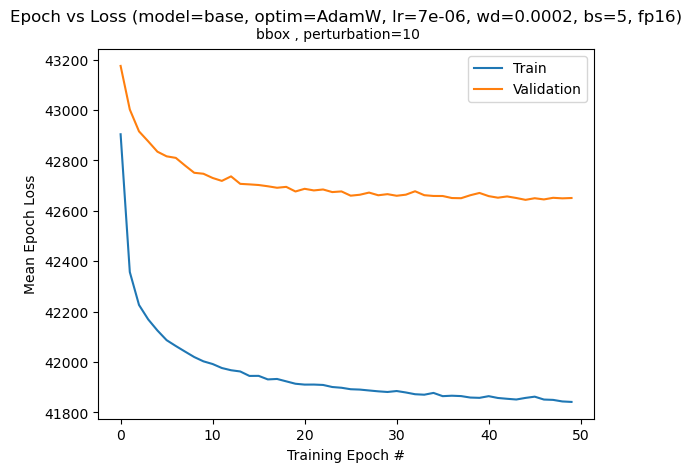

In [26]:
# train_losses = checkpoint["train_losses"]
# validation_losses = checkpoint["validation_losses"]

plt.plot([loss[0] for loss in train_losses], label="Train")
plt.plot([loss[0] for loss in validation_losses], label="Validation")

plt.title(f"Epoch vs Loss ({get_model_label()})", pad=20)
plt.suptitle(get_prompts_label(), y=0.925, fontsize=10)
plt.xlabel("Training Epoch #")
plt.ylabel("Mean Epoch Loss")
plt.legend();

In [27]:
loop = tqdm(total=len(eval_validation_dataloader), position=0)
print(
    "Average validation loss:", 
    evaluate_model(tuned_model, eval_validation_dataloader, device, loss_config, loop).item(),
)

  0%|          | 0/1374 [00:00<?, ?it/s]

Average validation loss: 42643.8046875
